In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["WANDB_DISABLED"] = "true"

import sys
# sys.path = ['/home/jxm3/research/retrieval/inversion'] + sys.path
sys.path = [
    p for p in sys.path
    if p not in ['/home/jxm3/research/prompting/imodelsX', '/home/jxm3/research/prompting/tree-prompt']
]
sys.path.append('/home/jxm3/research/retrieval/inversion')

In [22]:
# model info:
#    https://wandb.ai/jack-morris/emb-correct-1/runs/b93343310fcbae26f80da608a9e07cbd/overview?workspace=user-jxmorris12
#     abs       [in-progress sl 128 model, hasn't made it that far]
#             path: saves/474c3cf5cfb8d281b0abee9041b6cb5a

import analyze_utils

checkpoint_folder = '/home/jxm3/research/retrieval/inversion/saves/474c3cf5cfb8d281b0abee9041b6cb5a'
trainer = analyze_utils.load_trainer(checkpoint_folder, sanity_decode=False)

Loading trainer for analysis – setting --do_eval=1
loading alias gtr_nq__msl128_beta from /home/jxm3/research/retrieval/inversion/saves/8631b1c05efebde3077d16c5b99f6d5e/dc72e8b9c01bd27b0ed1c2def90bcee5...
Set train_args.dataloader_num_workers = 4


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/jxm3/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jxm3/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jxm3/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


================ Begin trainer sanity check ================
	Input to encode -> Twas brillig, and the slithy toves, Did gyre and gimble in the wabe, All mimsy were the borogoves, And the mome raths outgrabe.
	Decoded output shape ->  torch.Size([1, 128])
	Decoded output -> The sloes, the snags, and the wybies were the motte, the tobbies, The wavy slags, And the gybes, were the martyres, But the tybe was the nags and the martes, And all the bluffs, blies, and bliths were wry. The mesty came to the ring, And sighed, And sang, And came to writhe, And
================ End trainer sanity check ================
Froze 342572160 params from model type <class 'models.inversion.InversionModel'>


[nltk_data] Downloading package wordnet to /home/jxm3/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jxm3/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jxm3/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Visualize hypothesis distance

In [9]:
trainer.precompute_hypotheses()

Loading hypotheses from path /home/jxm3/research/retrieval/inversion/saves/8631b1c05efebde3077d16c5b99f6d5e/dc72e8b9c01bd27b0ed1c2def90bcee5/b6a7395774fafa6a965bc62eb29aa281/1db4edcafef34825_hypotheses.cache
Loading hypotheses from path /home/jxm3/research/retrieval/inversion/saves/8631b1c05efebde3077d16c5b99f6d5e/dc72e8b9c01bd27b0ed1c2def90bcee5/b6a7395774fafa6a965bc62eb29aa281/2ec5fd83e6fff43c_hypotheses.cache
Loading hypotheses from path /home/jxm3/research/retrieval/inversion/saves/8631b1c05efebde3077d16c5b99f6d5e/dc72e8b9c01bd27b0ed1c2def90bcee5/b6a7395774fafa6a965bc62eb29aa281/3575ad459a907cad_hypotheses.cache
Loading hypotheses from path /home/jxm3/research/retrieval/inversion/saves/8631b1c05efebde3077d16c5b99f6d5e/dc72e8b9c01bd27b0ed1c2def90bcee5/b6a7395774fafa6a965bc62eb29aa281/cc9236cb401ac674_hypotheses.cache
Loading hypotheses from path /home/jxm3/research/retrieval/inversion/saves/8631b1c05efebde3077d16c5b99f6d5e/dc72e8b9c01bd27b0ed1c2def90bcee5/b6a7395774fafa6a965bc62eb29

In [12]:
from typing import Dict
import torch

def add_distance_to_dataset(batch: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
    e1 = torch.tensor(batch["frozen_embeddings"], device="cpu")
    e2 = torch.tensor(batch["hypothesis_embedding"], device="cpu")
    batch["hypothesis_distance"] = torch.nn.CosineSimilarity(dim=1)(e1, e2).cpu()
    return batch

ds_with_distances = trainer.train_dataset.select(range(10**5)).map(add_distance_to_dataset, batched=True, batch_size=4096)

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

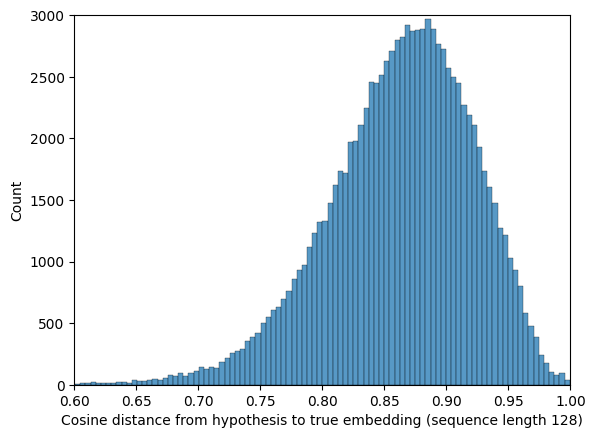

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn.displot
ax = sns.histplot(ds_with_distances["hypothesis_distance"], bins=150)

ax.set_xlim([.6,1])
ax.set_ylim([0, 3_000])
ax.set_xlabel("Cosine distance from hypothesis to true embedding (sequence length 128)")
# ax.set_xscale("log")

# save to PDF
plt.savefig("train_hypothesis_distance_sl128.pdf", format="pdf", bbox_inches="tight") 

## Decoding test

Need to always pad everything to max-length so we can decode variable-length texts and track the best ones we've seen.

In [19]:
trainer.model.eval()
trainer.sanity_decode()

================ Begin trainer sanity check ================
	Input to encode -> Twas brillig, and the slithy toves, Did gyre and gimble in the wabe, All mimsy were the borogoves, And the mome raths outgrabe.
IM.generate: {'early_stopping': False, 'num_beams': 1, 'do_sample': False, 'no_repeat_ngram_size': 0, 'max_length': 58}
CE.generate: {'early_stopping': False, 'num_beams': 1, 'do_sample': False, 'no_repeat_ngram_size': 3, 'min_length': 1, 'max_length': 128}
	Decoded output shape ->  torch.Size([1, 128])
	Decoded output -> The slugs were the mbbies, the slurred mbeys, and the wygbey. The wry mbereys were tyres, And the gygbbey was a slithe, And all the nags were torpedoes, The nagbey swaddled, And threw, And did the luge, and did the marmoset. The wily mbire, the wily marmos
================ End trainer sanity check ================


## Multi-round test

Our current model is getting around 11 BLEU. But does multi-round decoding help?

In [23]:
trainer.inversion_trainer.model.use_frozen_embeddings_as_input = True
trainer.gen_kwargs = {
    "early_stopping": False,
    "num_beams": 1,
    "do_sample": False,
    "no_repeat_ngram_size": 0,
}
trainer.num_gen_recursive_steps = 1
metrics = trainer.evaluate(
    eval_dataset=trainer.eval_dataset["nq"],
    metric_key_prefix="eval_nq",
)
print(metrics)

[pred] a fetus, and the fetus is slender and flattened, a characteristic of the mongoloid type. The morphological properties of the infant are often referred to as mongoloidized, a term that is used in reference to the tendency of the infant to have a small, flattened face, and the presence of a small, rounded skull in the infant. The fetal skull is also a source of the fetal epithelium, which is the internal structure of the skull, and the feta
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact the Mongoloid presents so many physical traits which are associated with the late fetus or young infant that he has been called a fetalized, infantilized or pedomorphic type. Those who have carefully observed young babies may recall that the root of the nose is frequently flat or low as in Mongoloids, and that an internal epicanthic fold in such instances is usually present. The smaller number of individual he

In [24]:
trainer.inversion_trainer.model.use_frozen_embeddings_as_input = True
trainer.gen_kwargs = {
    "early_stopping": False,
    "num_beams": 1,
    "do_sample": False,
    "no_repeat_ngram_size": 0,
}
trainer.num_gen_recursive_steps = 5
metrics = trainer.evaluate(
    eval_dataset=trainer.eval_dataset["nq"],
    metric_key_prefix="eval_nq",
)
print(metrics)

[pred] a morphologically primitive type of infant, the morphological features of the infant are characterized by the presence of a small, flattened, and slender fetus, which is a characteristic of all monoids, and is also present in many other types of monoids. The fetus is often referred to as infantized, because the lateral and posterior surfaces of the skull are slender and flattened, and the posterior surface of the chin is slender and flattened. The lateral surface of the 
[true] to the character of the sutures of the skull which, like those of the infant skull, are relatively smooth and untortuous. In fact the Mongoloid presents so many physical traits which are associated with the late fetus or young infant that he has been called a fetalized, infantilized or pedomorphic type. Those who have carefully observed young babies may recall that the root of the nose is frequently flat or low as in Mongoloids, and that an internal epicanthic fold in such instances is usually present. Th